# Importing Libraries & datasets

In [598]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [416]:
df1 = pd.read_excel("dataset\ProductA.xlsx")
df2 = pd.read_excel("dataset\ProductA_google_clicks.xlsx")
df3 = pd.read_excel("dataset\ProductA_fb_impressions.xlsx")

# Data Preprocessing

### Merging datasets

In [417]:
df4 = pd.merge(df1, df2, on="Day Index", how="left")        # left joined
df = pd.merge(df4, df3, on="Day Index", how="left")

In [418]:
df.to_excel('final_df.xlsx', index=False)   # exporitng the final dataset for further analysis

In [419]:
df.head()

,Day Index,Quantity,Clicks,Impressions
0,2021-12-01,14,445,620
1,2021-12-02,10,433,890
2,2021-12-03,13,424,851
3,2021-12-04,22,427,881
4,2021-12-05,33,451,678


### Descriptive Statistics

In [420]:
df.shape

(212, 4)

| Rows | Columns |
|------|---------|
| 212  | 4       |


In [421]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day Index    212 non-null    datetime64[ns]
 1   Quantity     212 non-null    int64         
 2   Clicks       212 non-null    int64         
 3   Impressions  212 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.8 KB


In [422]:
df.describe()

,Day Index,Quantity,Clicks,Impressions
count,212,212.000000,212.00000,212.000000
mean,2022-03-16 12:00:00,17.542453,358.20283,1531.702830
min,2021-12-01 00:00:00,5.000000,60.00000,620.000000
25%,2022-01-22 18:00:00,13.750000,154.00000,1209.750000
50%,2022-03-16 12:00:00,17.000000,402.50000,1460.000000
75%,2022-05-08 06:00:00,21.000000,492.75000,1862.000000
max,2022-06-30 00:00:00,38.000000,726.00000,2707.000000
std,NaN,5.790423,164.52160,440.660783


### Missing values - Imputation

In [423]:
print("NULL Values:")
df.isnull().sum()

NULL Values:


Day Index      0
Quantity       0
Clicks         0
Impressions    0
dtype: int64

Hence, there are no NULL values. So, No imputation needed.

### Dropping Duplicates

In [424]:
df.shape

(212, 4)

In [425]:
df.drop_duplicates()

,Day Index,Quantity,Clicks,Impressions
0,2021-12-01,14,445,620
1,2021-12-02,10,433,890
2,2021-12-03,13,424,851
3,2021-12-04,22,427,881
4,2021-12-05,33,451,678
...,...,...,...,...
207,2022-06-26,13,114,1218
208,2022-06-27,16,106,1311
209,2022-06-28,13,109,885
210,2022-06-29,16,60,1000


No row dropped after drop_duplicates() ! Hence, No duplicates found! 


### Analysing Outliers

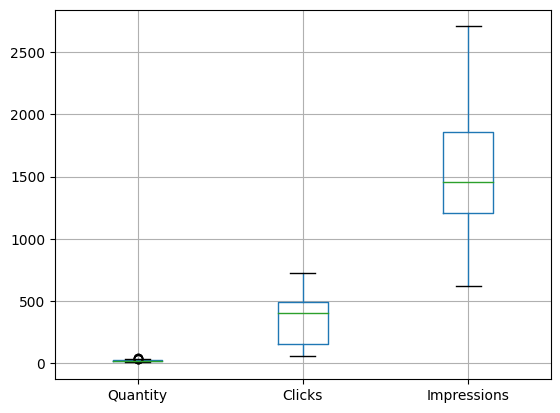

In [426]:
plt.figure()
df.boxplot()
plt.show()

In [427]:
def find_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outliers

print("Outliers in each dependent attribute:")
print(f"Quantity:\t {len(find_outliers_IQR(df['Quantity']))}")
print(f"Clicks:\t\t {len(find_outliers_IQR(df['Clicks']))}")
print(f"Impressions:\t {len(find_outliers_IQR(df['Impressions']))}")

Outliers in each dependent attribute:
Quantity:	 5
Clicks:		 0
Impressions:	 0


So, there are 5 outliers in the *Quantity* attribute

In [428]:
print(f"Quantity:\n{find_outliers_IQR(df['Quantity'])}")

Quantity:
4      33
9      38
78     38
113    32
142    36
Name: Quantity, dtype: int64


***

### Replacing Outliers with 97th percentile value

In [429]:
percentile_95_value = df["Quantity"].quantile(0.97)
print(percentile_95_value)

30.669999999999987


In [430]:
def impute_outliers_97th_percentile(series):
    q1, q3 = series.quantile([0.25, 0.75])
    IQR = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * IQR, q3 + 1.5 * IQR
    percentile_95_value = series.quantile(0.97)
    return series.apply(lambda x: percentile_95_value if x < lower_bound or x > upper_bound else x)

In [431]:
df['imputed_Quantity'] = impute_outliers_97th_percentile(df['Quantity'])

In [432]:
print("Outliers in each dependent attribute:")
print(f"Quantity:\t {len(find_outliers_IQR(df['imputed_Quantity']))}")

Outliers in each dependent attribute:
Quantity:	 0


Hence, the outliers are replaced by 97th percentile values.

# Feature Engineering

In [433]:
df.head()

,Day Index,Quantity,Clicks,Impressions,imputed_Quantity
0,2021-12-01,14,445,620,14.00
1,2021-12-02,10,433,890,10.00
2,2021-12-03,13,424,851,13.00
3,2021-12-04,22,427,881,22.00
4,2021-12-05,33,451,678,30.67


Imputed_Quantity signifies the quantity column where outliers are set on 97th percentile.

In [434]:
df['imputed_Quantity'] = impute_outliers_97th_percentile(df['Quantity'])

Log Tranformed attributes

In [435]:
df['log_Quantity'] = np.log1p(df['Quantity'])
df['log_Clicks'] = np.log1p(df['Clicks'])
df['log_Impressions'] = np.log1p(df['Impressions'])

Extract Month and Year

In [436]:
df['YearMonth'] = df['Day Index'].dt.to_period('M')

Extract Month Name

In [549]:
df['MonthName'] = df['YearMonth'].dt.strftime('%B')
month_order = ['December', 'January', 'February', 'March', 'April', 'May', 'June']  
df['MonthName'] = pd.Categorical(df['MonthName'], categories=month_order, ordered=True)

Extract day of the Week

In [550]:
df['DayOfWeek'] = df['Day Index'].dt.day_name()
week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']  
df['DayOfWeek'] = pd.Categorical(df['DayOfWeek'], categories=week_order, ordered=True)

Reindexing the attributes for better understanding and clear view of the data


In [551]:
order = ["Day Index", "YearMonth", "MonthName", "DayOfWeek", "Quantity", "Clicks", "Impressions", "imputed_Quantity", "log_Quantity", "log_Clicks", "log_Impressions"]
df = df[order]

final data

In [552]:
df.head()

,Day Index,YearMonth,MonthName,DayOfWeek,Quantity,Clicks,Impressions,imputed_Quantity,log_Quantity,log_Clicks,log_Impressions
0,2021-12-01,2021-12,December,Wednesday,14,445,620,14.00,2.708050,6.100319,6.431331
1,2021-12-02,2021-12,December,Thursday,10,433,890,10.00,2.397895,6.073045,6.792344
2,2021-12-03,2021-12,December,Friday,13,424,851,13.00,2.639057,6.052089,6.747587
3,2021-12-04,2021-12,December,Saturday,22,427,881,22.00,3.135494,6.059123,6.782192
4,2021-12-05,2021-12,December,Sunday,33,451,678,30.67,3.526361,6.113682,6.520621


In [553]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Day Index         212 non-null    datetime64[ns]
 1   YearMonth         212 non-null    period[M]     
 2   MonthName         212 non-null    category      
 3   DayOfWeek         212 non-null    category      
 4   Quantity          212 non-null    int64         
 5   Clicks            212 non-null    int64         
 6   Impressions       212 non-null    int64         
 7   imputed_Quantity  212 non-null    float64       
 8   log_Quantity      212 non-null    float64       
 9   log_Clicks        212 non-null    float64       
 10  log_Impressions   212 non-null    float64       
dtypes: category(2), datetime64[ns](1), float64(4), int64(3), period[M](1)
memory usage: 16.1 KB



# Data Analysis

### Correlation Heatmap

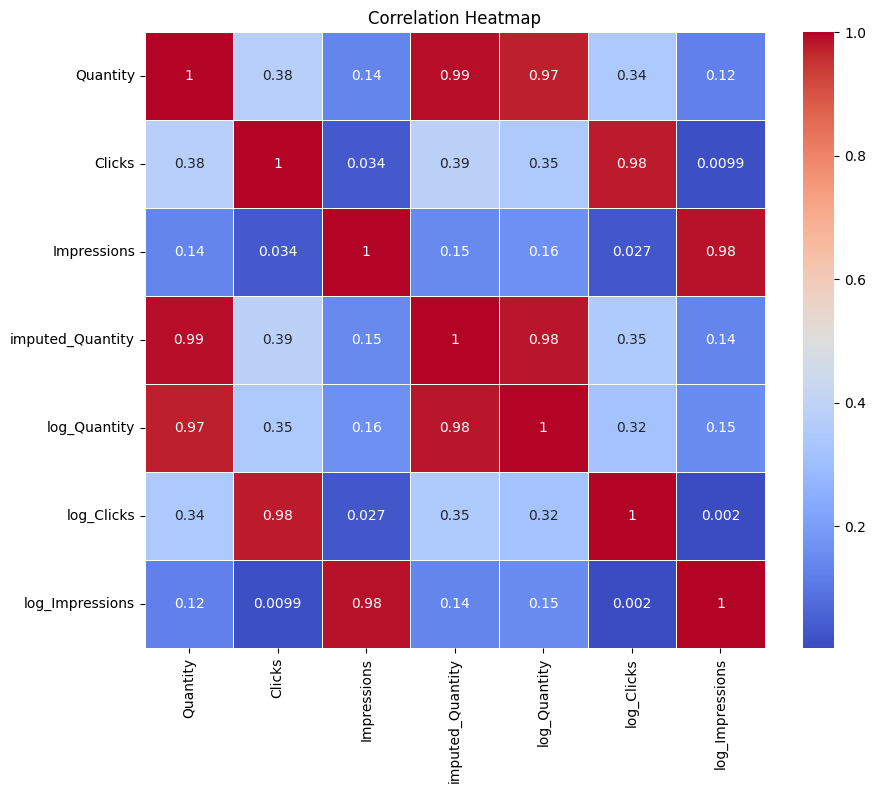

In [597]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True,  cmap='coolwarm', linewidths=0.5).set_title("Correlation Heatmap")
plt.show()

Through the above correlation heatmap, we can say that :
* Clicks have good correlation with Quantity
* Impressions also have slight relation to Quantity
* Impression have very tiny relation to clicks


### 1. How Clicks affect the Product's quantity?

<i>Function for plotting Linear Regression

In [442]:
# Define function for plotting regression
def plot_regression(df, x_col, y_col, title, ax):
    x = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values
    
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    slope = model.coef_[0]
    
    ax.scatter(df[x_col], df[y_col], label='Actual Data')
    ax.plot(df[x_col], y_pred, color='red', label='Regression Line')
    ax.set_title(title)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.legend()
    return slope

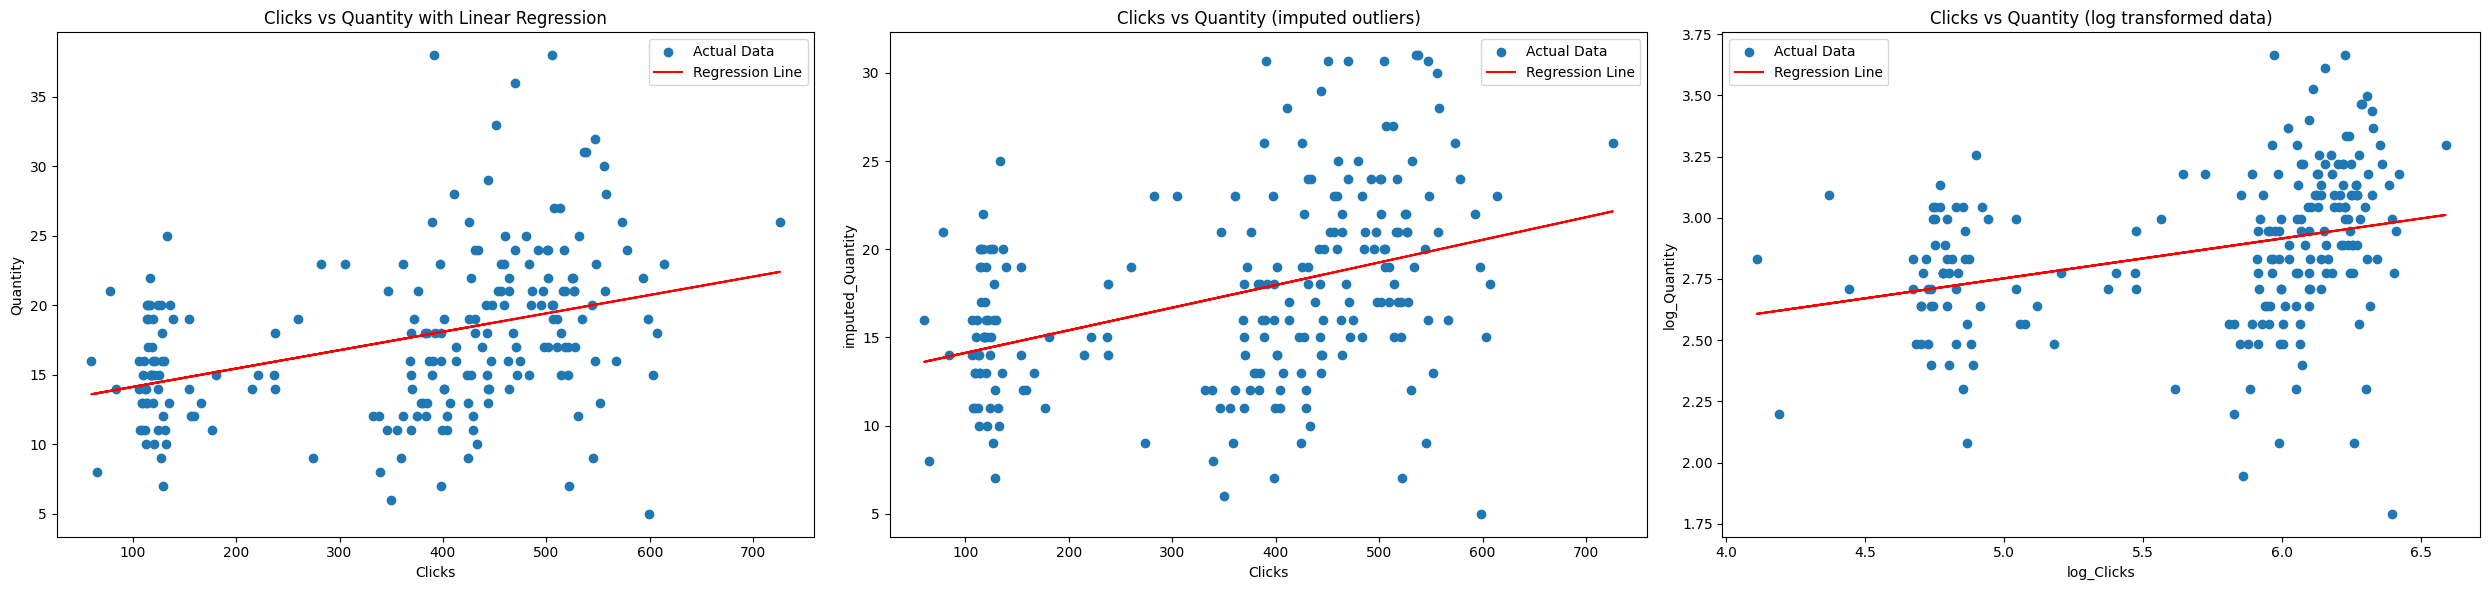

The slope of the linear regression model for original data is: 0.013234961483654805
The slope of the linear regression model for data with imputed outliers is: 0.012818303346978916
The slope of the linear regression model for log transformed data is: 0.16298656613150664


In [443]:
# Create subplots for plotting
fig, axes = plt.subplots(1, 3, figsize=(25, 6))

# Plotting regression for different scenarios
slope_original = plot_regression(df, 'Clicks', 'Quantity', 'Clicks vs Quantity with Linear Regression', axes[0])
imputed_slope = plot_regression(df, 'Clicks', 'imputed_Quantity', 'Clicks vs Quantity (imputed outliers)', axes[1])
slope_log = plot_regression(df, 'log_Clicks', 'log_Quantity', 'Clicks vs Quantity (log transformed data)', axes[2])

plt.tight_layout()
plt.show()

# Print slopes
print(f"The slope of the linear regression model for original data is: {slope_original}")
print(f"The slope of the linear regression model for data with imputed outliers is: {imputed_slope}")
print(f"The slope of the linear regression model for log transformed data is: {slope_log}")

Hence, there is a relation with +ve slope, i.e. Quantity increases as Clicks increases.
***

### 2. How Impressions affect the Product's quantity?

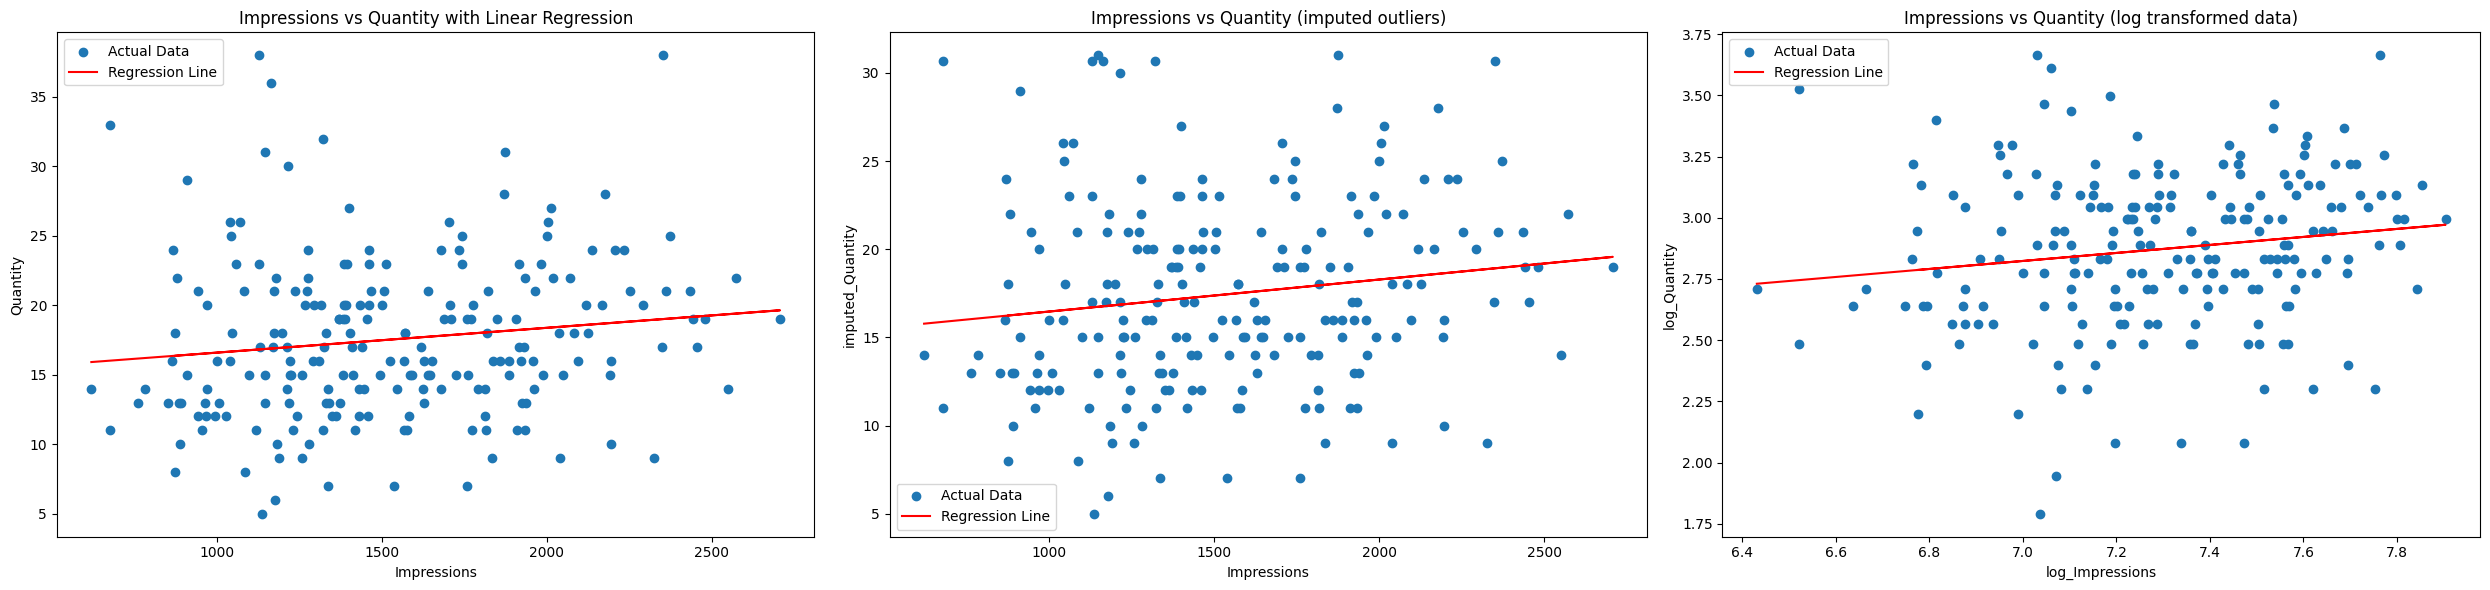

The slope of the linear regression model for original data is: 0.0017863293104571235
The slope of the linear regression model for data with imputed outliers is: 0.0018151514524222265
The slope of the linear regression model for log transformed data is: 0.16352913564679306


In [444]:
# Create subplots for plotting
fig, axes = plt.subplots(1, 3, figsize=(25, 6))

# Plotting regression for different scenarios
slope_original = plot_regression(df, 'Impressions', 'Quantity', 'Impressions vs Quantity with Linear Regression', axes[0])
imputed_slope = plot_regression(df, 'Impressions', 'imputed_Quantity', 'Impressions vs Quantity (imputed outliers)', axes[1])
slope_log = plot_regression(df, 'log_Impressions', 'log_Quantity', 'Impressions vs Quantity (log transformed data)', axes[2])

plt.tight_layout()
plt.show()

# Print slopes
print(f"The slope of the linear regression model for original data is: {slope_original}")
print(f"The slope of the linear regression model for data with imputed outliers is: {imputed_slope}")
print(f"The slope of the linear regression model for log transformed data is: {slope_log}")

Hence, there is a +ve slope that means an increase in impressions can slightly increase the quantity demanded.
***

### 3. Does more impressions lead to more clicks?

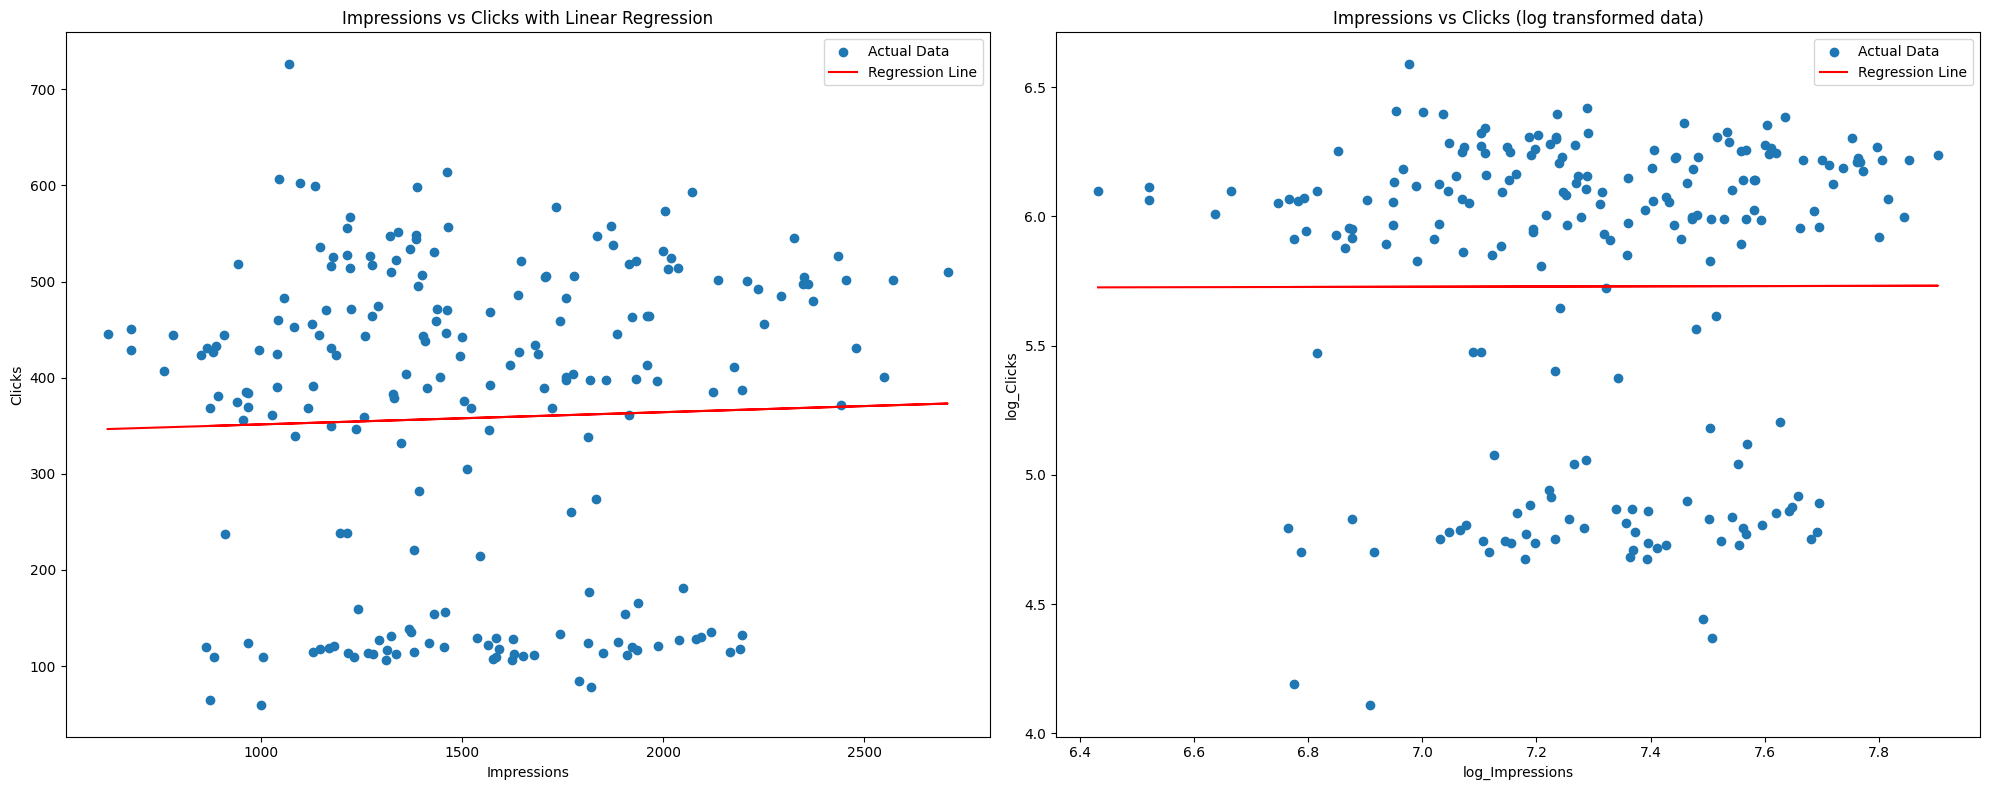

The slope of the linear regression model for original data is: 0.012709310479620622
The slope of the linear regression model for log transformed data is: 0.004241626376529049


In [445]:
# Create subplots for plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plotting regression for different scenarios
slope_original = plot_regression(df, 'Impressions', 'Clicks', 'Impressions vs Clicks with Linear Regression', axes[0])
slope_log = plot_regression(df, 'log_Impressions', 'log_Clicks', 'Impressions vs Clicks (log transformed data)', axes[1])

plt.tight_layout()
plt.show()

# Print slopes
print(f"The slope of the linear regression model for original data is: {slope_original}")
print(f"The slope of the linear regression model for log transformed data is: {slope_log}")

Hence the slope is +ve and thus proves the hypothesis that More impressions leads to more clicks.
***

### 4. Day wise plot for all 7 month data

#### 4.1 For Quantity

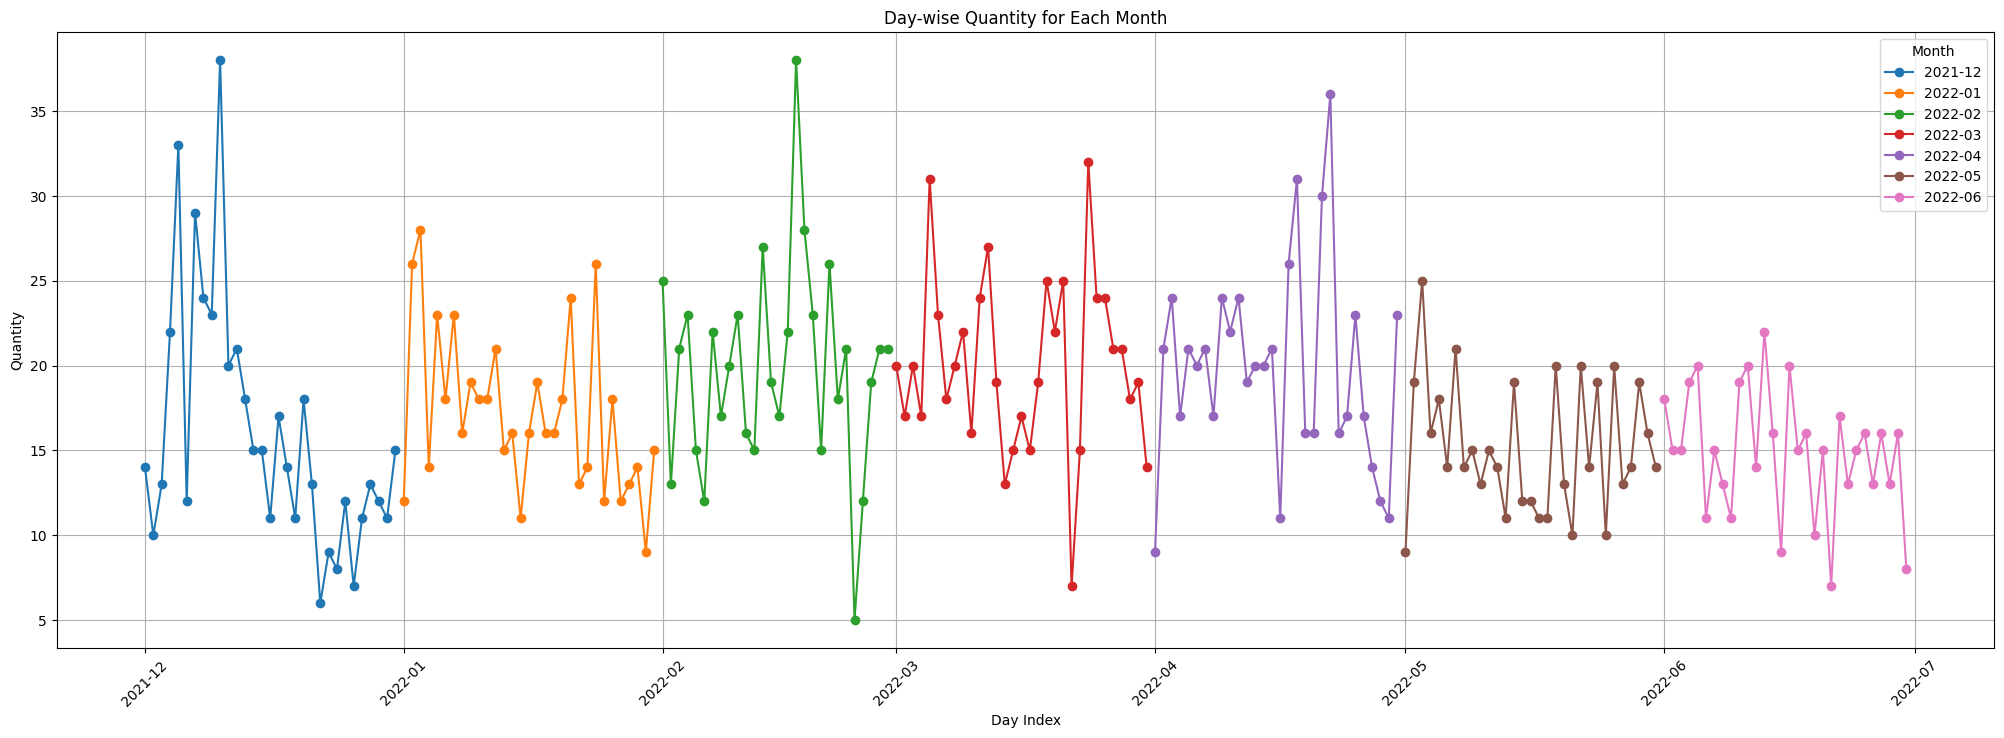

In [446]:
# Create a figure
plt.figure(figsize=(25, 8))

# Iterate over each month and plot the data
for month in df['YearMonth'].unique():
    monthly_data = df[df['YearMonth'] == month]
    plt.plot(monthly_data['Day Index'], monthly_data['Quantity'], marker='o', linestyle='-', label=str(month))

# Add title and labels
plt.title('Day-wise Quantity for Each Month')
plt.xlabel('Day Index')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.legend(title='Month', loc='best')
plt.grid(True)

# Show the plot
plt.show()


There are more peaks in the month of december, march, april and may.

#### 4.2 For Clicks

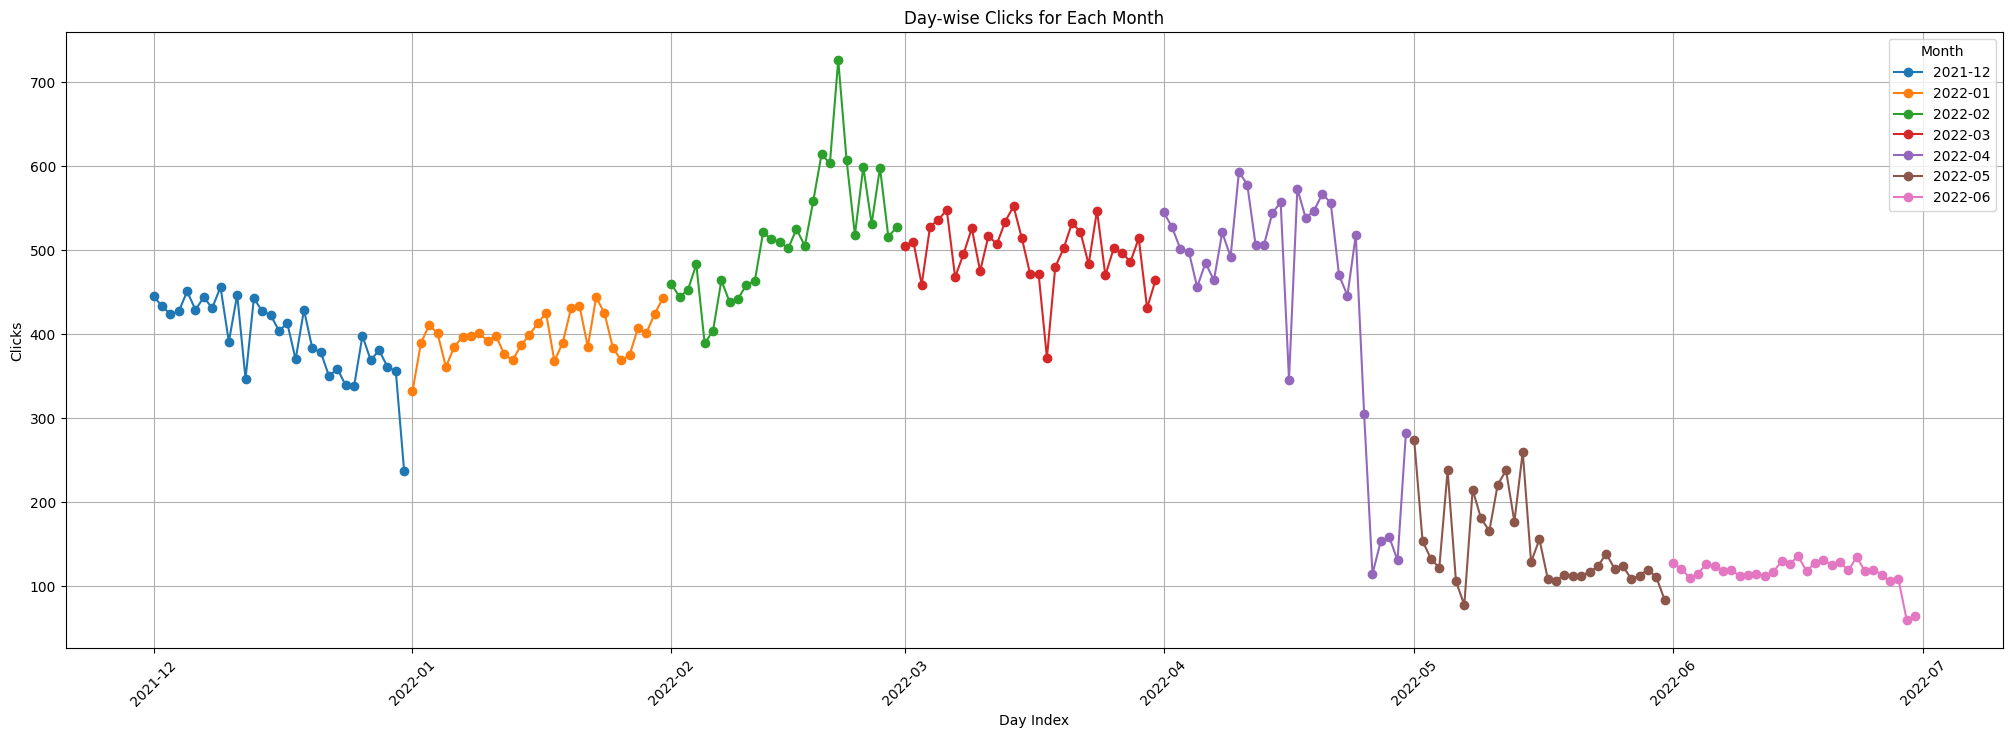

In [447]:
# Create a figure
plt.figure(figsize=(25, 8))

# Iterate over each month and plot the data
for month in df['YearMonth'].unique():
    monthly_data = df[df['YearMonth'] == month]
    plt.plot(monthly_data['Day Index'], monthly_data['Clicks'], marker='o', linestyle='-', label=str(month))

# Add title and labels
plt.title('Day-wise Clicks for Each Month')
plt.xlabel('Day Index')
plt.ylabel('Clicks')
plt.xticks(rotation=45)
plt.legend(title='Month', loc='best')
plt.grid(True)

# Show the plot
plt.show()


Month of May and June have loswest Clicks, while februaury has highest peak

#### 4.3 For Impressions

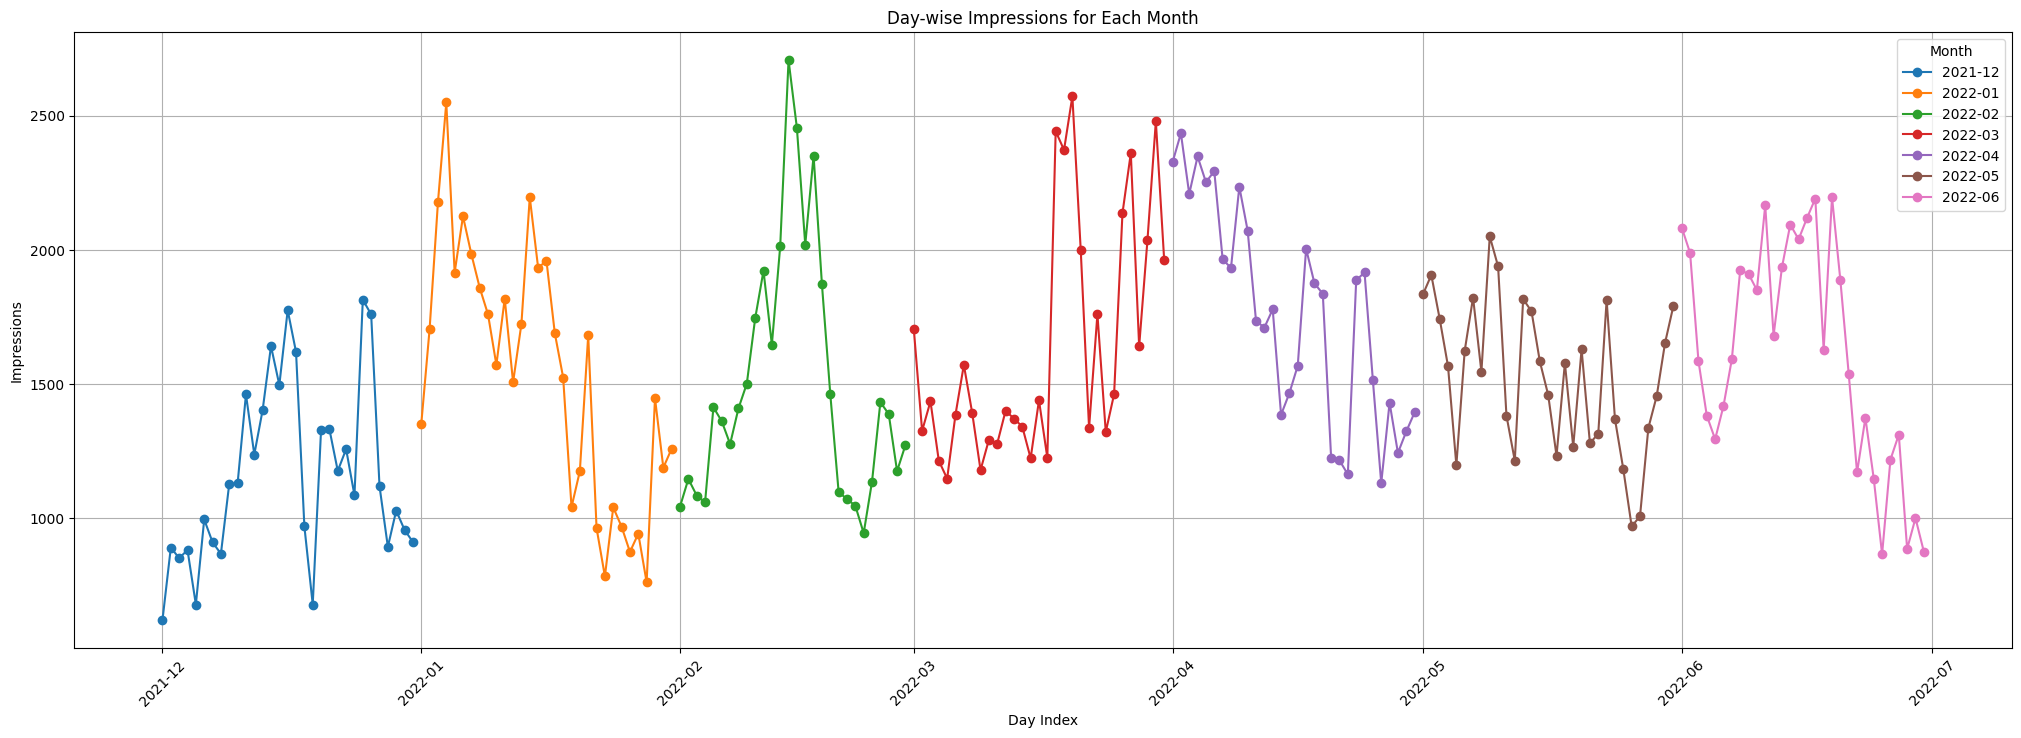

In [448]:
# Create a figure
plt.figure(figsize=(25, 8))

# Iterate over each month and plot the data
for month in df['YearMonth'].unique():
    monthly_data = df[df['YearMonth'] == month]
    plt.plot(monthly_data['Day Index'], monthly_data['Impressions'], marker='o', linestyle='-', label=str(month))

# Add title and labels
plt.title('Day-wise Impressions for Each Month')
plt.xlabel('Day Index')
plt.ylabel('Impressions')
plt.xticks(rotation=45)
plt.legend(title='Month', loc='best')
plt.grid(True)

# Show the plot
plt.show()


Highest peak of impressions is in the month of March, followed by February and april.

### 5. Monthly plot

#### 5.1 For quantity

In [586]:
def annotate_points(ax, x, y, values):
    for i, txt in enumerate(values):
        ax.annotate(f'{txt:.0f}', (x[i], y[i]), textcoords="offset points", xytext=(0,5), ha='center')

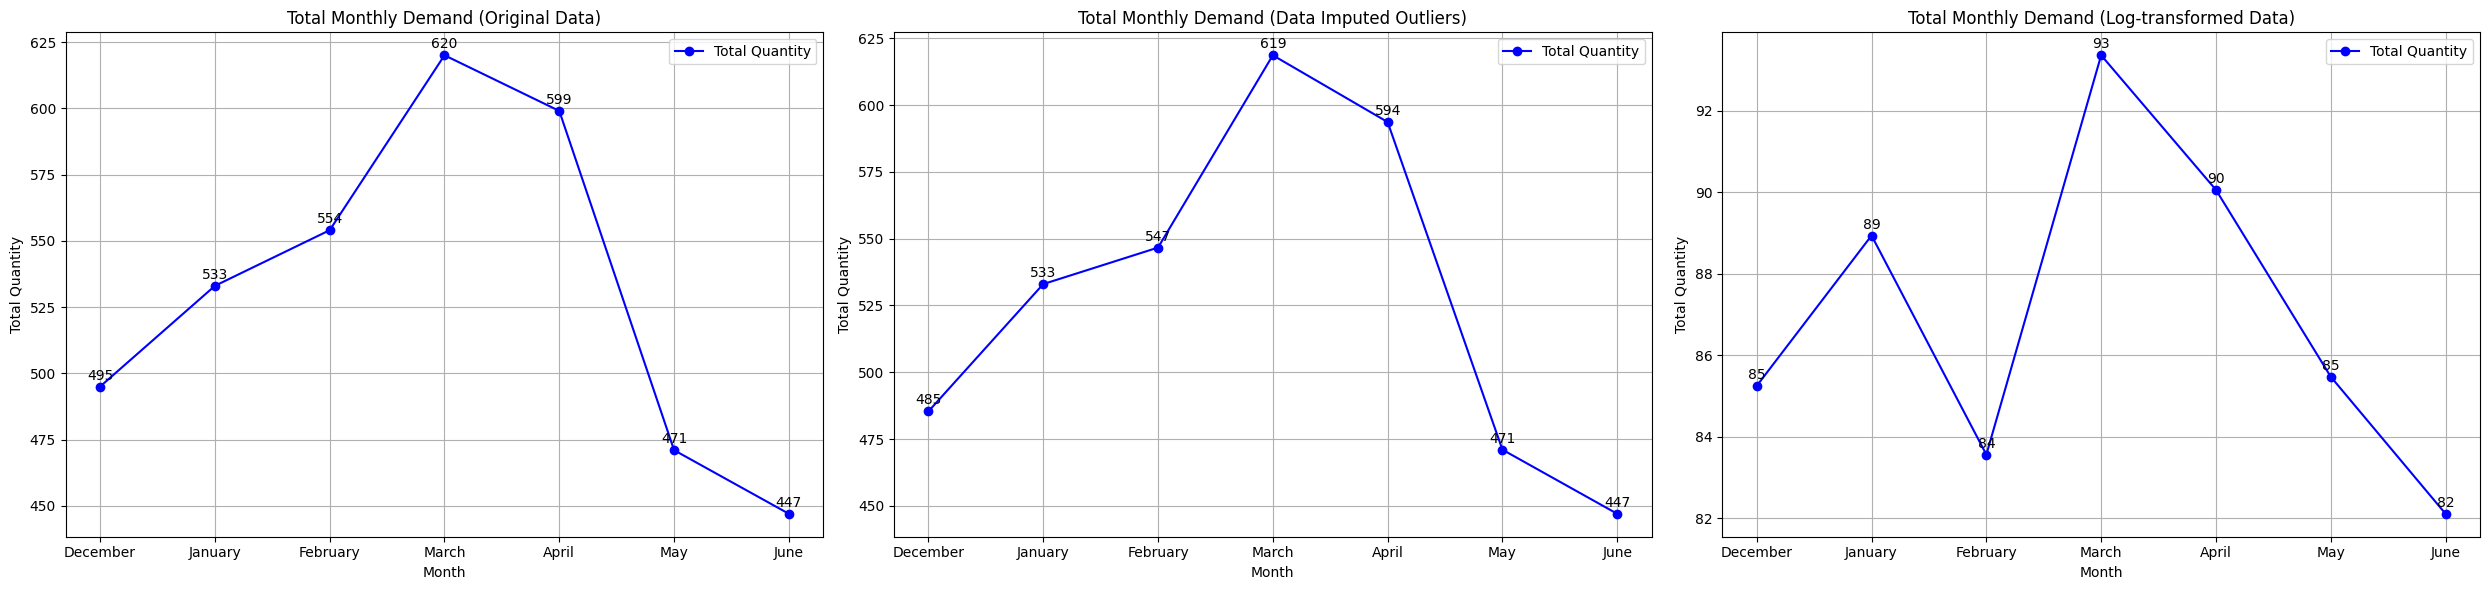

In [587]:
def plot_monthly_demand(df, x_col, y_col, title, ax):
    df1 = df.groupby(x_col)[y_col].sum().reset_index()
    df1 = df1.sort_values(by=x_col)
    ax.plot(df1[x_col], df1[y_col], marker='o', color='blue', label='Total Quantity')
    annotate_points(ax, df1[x_col], df1[y_col], df1[y_col])
    del df1
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Total Quantity')
    ax.grid(True)
    ax.legend()

# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(25, 6))

plot_monthly_demand(df, 'MonthName', 'Quantity', 'Total Monthly Demand (Original Data)', axes[0])
plot_monthly_demand(df, 'MonthName', 'imputed_Quantity', 'Total Monthly Demand (Data Imputed Outliers)', axes[1])
plot_monthly_demand(df, 'MonthName', 'log_Quantity', 'Total Monthly Demand (Log-transformed Data)', axes[2])

plt.tight_layout()
plt.show()

* Hence, the total quantity demanded of Product A increases as winters arrive and reaches its peak in March and then declines rapidly.
* Peak 1 --> March (03-2022)
* Peak 2 --> April (04-2022)
***

#### 5.2 For quantity, clicks and impressions aggregated plot

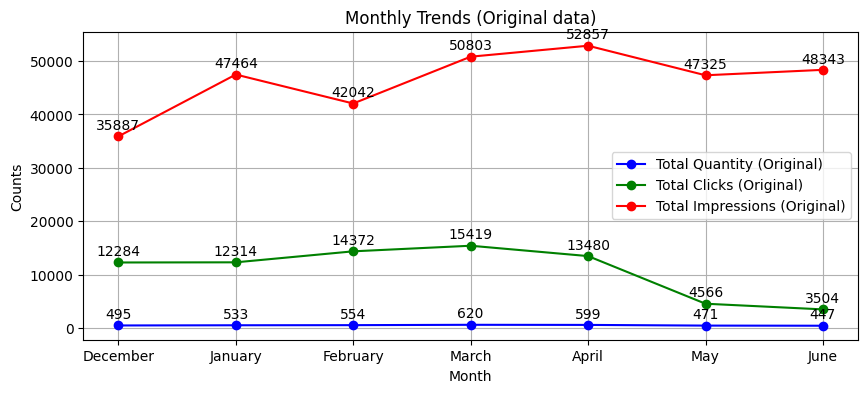

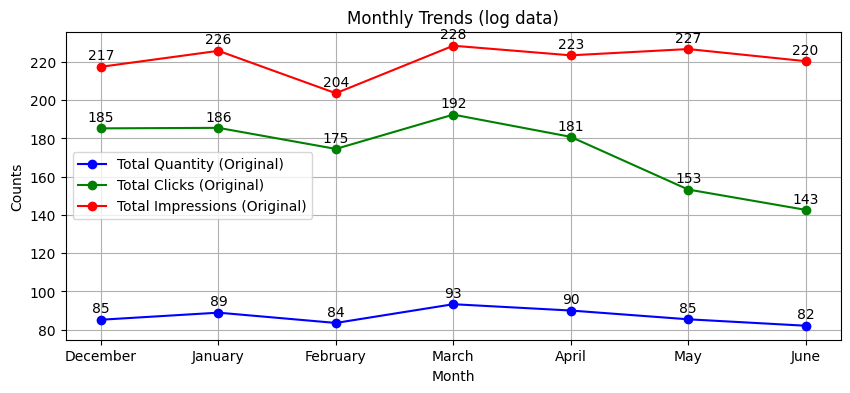

In [580]:
def plot_aggregated_monthly(df, x_col, y_cols, colors, labels, title):
    plt.figure(figsize=(10, 4))
    ax = plt.gca()
    for y_col, color, label in zip(y_cols, colors, labels):
        df1 = df.groupby(x_col)[y_col].sum().reset_index()
        df1 = df1.sort_values(by=x_col)
        plt.plot(df1[x_col], df1[y_col], marker='o', color=color, label=label)
        annotate_points(ax, df1[x_col], df1[y_col], df1[y_col])
        del df1

    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Counts')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_aggregated_monthly(df, 'MonthName', ['Quantity', 'Clicks', 'Impressions'], ['blue', 'green', 'red'], ['Total Quantity (Original)', 'Total Clicks (Original)', 'Total Impressions (Original)'], 'Monthly Trends (Original data)')
plot_aggregated_monthly(df, 'MonthName', ['log_Quantity', 'log_Clicks', 'log_Impressions'], ['blue', 'green', 'red'], ['Total Quantity (Original)', 'Total Clicks (Original)', 'Total Impressions (Original)'], 'Monthly Trends (log data)')

* As we can see in the above log transformed one, we can see that in the month of march (03-2022), all 3 attributes hit their peaks.
* Meanwhile in all 3 plots, impressions and quantity peaks in march .

### 6. Day of the Week wise plot

#### 6.1 For Quantity

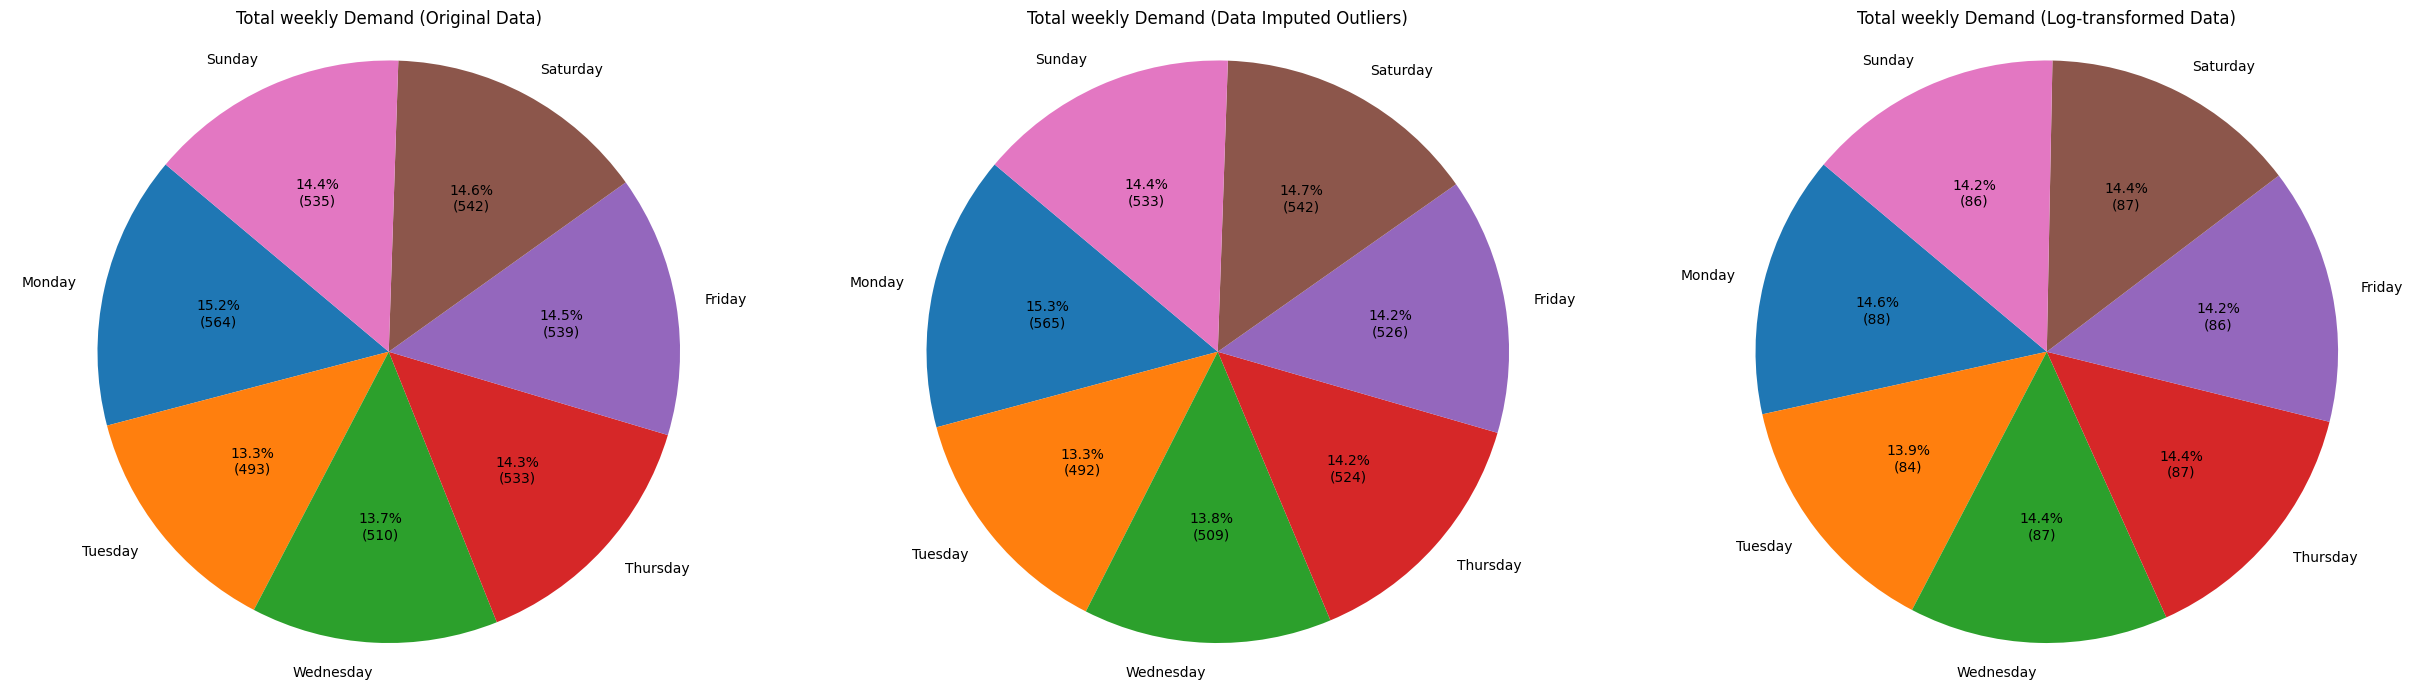

In [579]:
def plot_weekly_demand(df, x_col, y_col, title, ax):
    df1 = df.groupby(x_col)[y_col].sum().reset_index()
    df1 = df1.sort_values(by=x_col)
    labels = df1[x_col]
    sizes = df1[y_col]
    ax.pie(sizes, labels=labels, autopct=lambda pct: f'{pct:.1f}%\n({int(pct * sum(sizes) / 100)})', startangle=140)
    ax.set_title(title)
    ax.axis('equal')
    del df1

# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(25, 7))
plot_weekly_demand(df, 'DayOfWeek', 'Quantity', 'Total weekly Demand (Original Data)', axes[0])
plot_weekly_demand(df, 'DayOfWeek', 'imputed_Quantity', 'Total weekly Demand (Data Imputed Outliers)', axes[1])
plot_weekly_demand(df, 'DayOfWeek', 'log_Quantity', 'Total weekly Demand (Log-transformed Data)', axes[2])
plt.tight_layout()
plt.show()

As we can derive 2 conclusions from the total Product's quantity of each day:
* Monday accounts for the highest Product's quantity demand.
* Tuesdays accounts for the lowest Product's quantity demand.

***

#### 6.2 For Quantity, Clicks and Impressions Aggregated

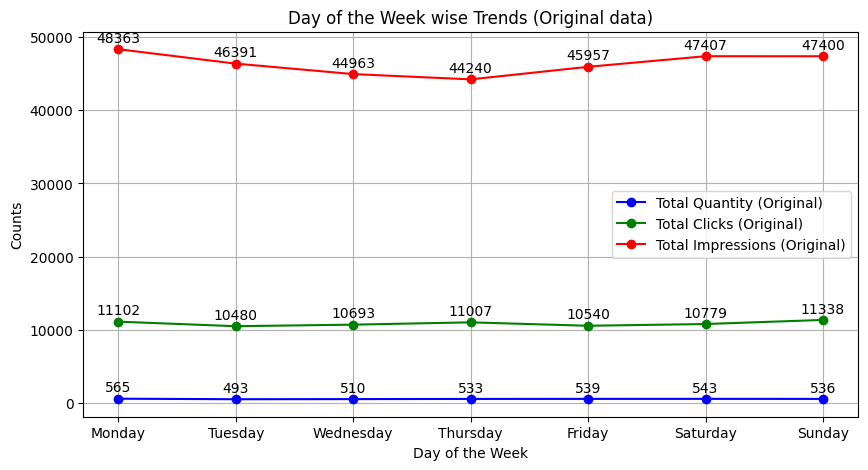

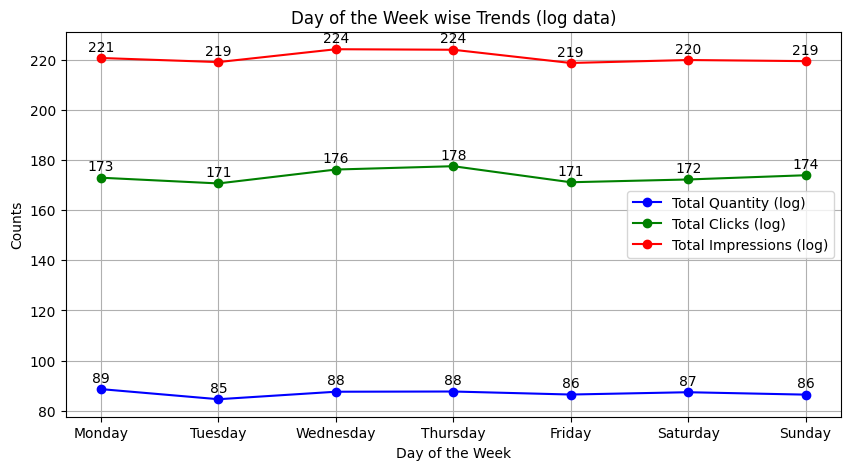

In [594]:
def plot_aggregated_weekly(df, x_col, y_cols, colors, labels, title):
    plt.figure(figsize=(10, 5))
    ax = plt.gca()

    for y_col, color, label in zip(y_cols, colors, labels):
        df1 = df.groupby(x_col)[y_col].sum().reset_index()
        df1 = df1.sort_values(by=x_col)
        plt.plot(df1[x_col], df1[y_col], marker='o', color=color, label=label)
        annotate_points(ax, df1[x_col], df1[y_col], df1[y_col])
        del df1
    plt.title(title)
    plt.xlabel('Day of the Week')
    plt.ylabel('Counts')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_aggregated_weekly(df, 'DayOfWeek', ['Quantity', 'Clicks', 'Impressions'], ['blue', 'green', 'red'], ['Total Quantity (Original)', 'Total Clicks (Original)', 'Total Impressions (Original)'], 'Day of the Week wise Trends (Original data)')
plot_aggregated_weekly(df, 'DayOfWeek', ['log_Quantity', 'log_Clicks', 'log_Impressions'], ['blue', 'green', 'red'], ['Total Quantity (log)', 'Total Clicks (log)', 'Total Impressions (log)'], 'Day of the Week wise Trends (log data)')

From the plot, we can derive following conclusions:
* <i>in original data plot</i>
    * Weekends (saturday, sundays) and monday have high impressions and clicks
    * Also, Thursday accounts for highest clicks
* <i>in log-transformed data plot</i> 
    * Wednesday and Thursday accounts for high impressions and clicks 

***
# Time Series Analysis


### Checking Stationarity of the Data

In [217]:
def adfuller_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

# Perform Dickey-Fuller test on the data
for i in list(["Quantity", "Clicks", "Impressions"]):
    print(f"ADF Test for {i}:")
    adfuller_test(df[i])
    print("-"*40)


ADF Test for Quantity:
ADF Statistic: -4.445717448758575
p-value: 0.00024615679644112006
Critical Values:
	1%: -3.4621857592784546
	5%: -2.875537986778846
	10%: -2.574231080806213
----------------------------------------
ADF Test for Clicks:
ADF Statistic: -0.8705717270828215
p-value: 0.797509057499528
Critical Values:
	1%: -3.4620315036789666
	5%: -2.8754705024827127
	10%: -2.5741950726860647
----------------------------------------
ADF Test for Impressions:
ADF Statistic: -5.6962061101258685
p-value: 7.863580125889645e-07
Critical Values:
	1%: -3.46172743446274
	5%: -2.8753374677799957
	10%: -2.574124089081557
----------------------------------------


<b><i>Data series is stationary for Quantity and Impressions attribute.

<i>For Quantity, the ADF Statistic is significantly negative (-4.45) and the p-value (0.0002) is very low, indicating strong evidence against the presence of a unit root. Therefore, Quantity is likely stationary.<p>
For Clicks, the ADF Statistic is closer to zero (-0.87) and the p-value (0.7975) is high, indicating weak evidence against the null hypothesis. Clicks are likely non-stationary.<p>
For Impressions, the ADF Statistic is highly negative (-5.70) and the p-value (approximately 0) is extremely low, indicating strong evidence against the presence of a unit root. Impressions are likely stationary.

### Plotting ACF and PACF plots

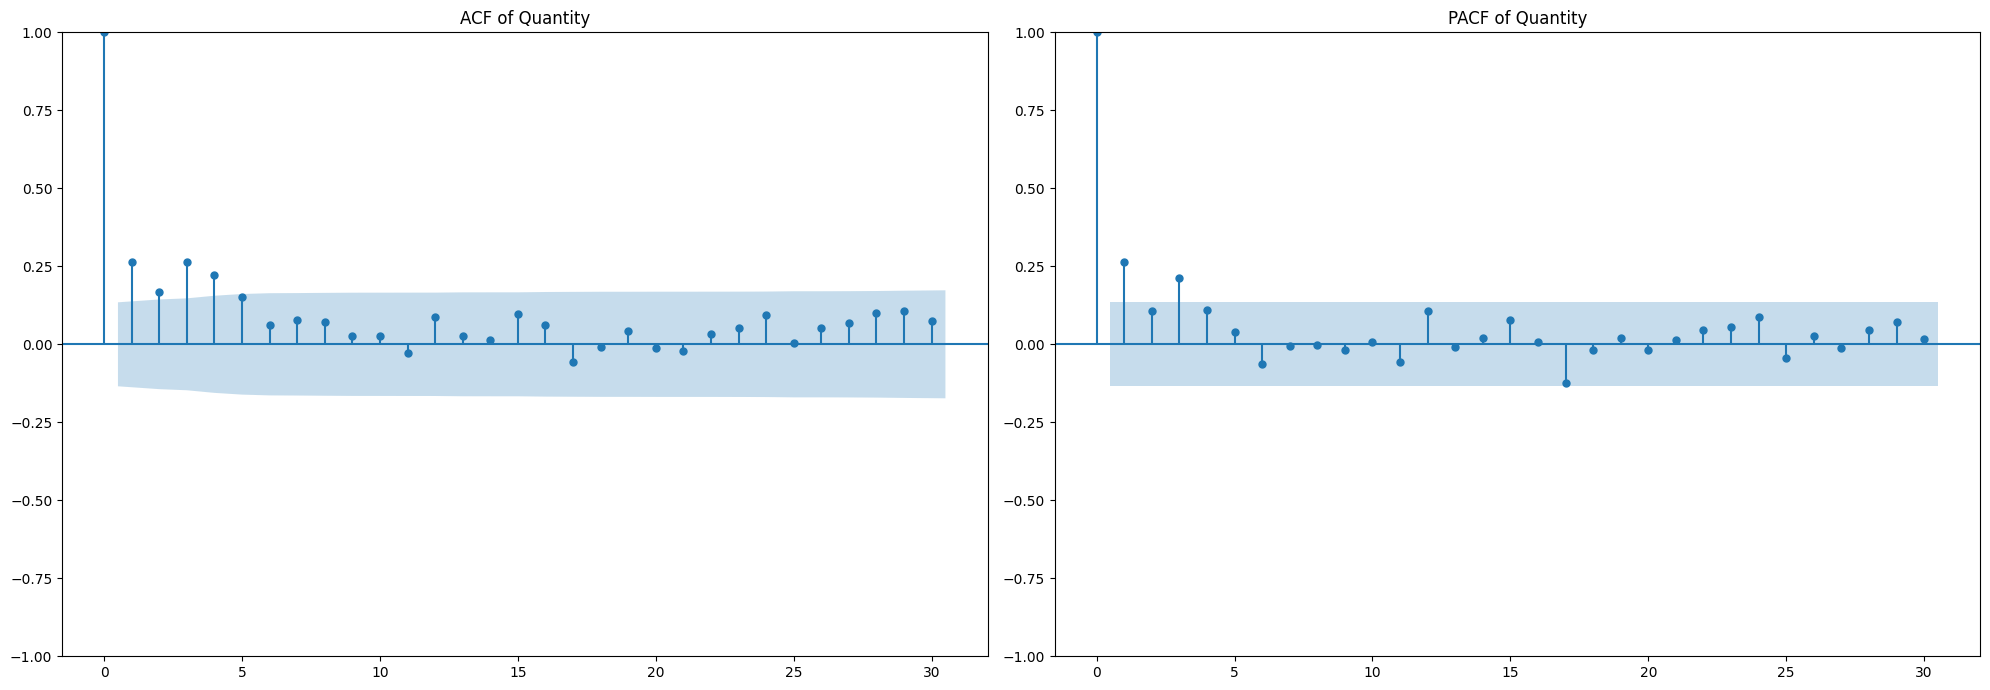

In [218]:
# Create subplots for ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# ACF plot
plot_acf(df['Quantity'], lags=30, ax=ax1)
ax1.set_title('ACF of Quantity')

# PACF plot
plot_pacf(df['Quantity'], lags=30, ax=ax2)
ax2.set_title('PACF of Quantity')

plt.tight_layout()
plt.show()


### Determining Optimal Parameters

<i><b>Value of differencing is zero, d = 0.</b> (Since, data series for quantity is stationary)<p>
<i><b>And The value of p = 1 and q = 1 for Quantity.</b> (Since each plot have a single biggest spike)<p>

### Data Splitting

<table>
  <tr>
    <th>Data set</th>
    <th>percentage</th>
    <th>Num of days</th>
  </tr>
  <tr>
    <td>train set</td>
    <td>60 %</td>
    <td>127 days</td>
  </tr>
  <tr>
    <td>validation set</td>
    <td>20 %</td>
    <td>42 days</td>
  </tr>
  <tr>
    <td>test set</td>
    <td>20 %</td>
    <td>43 days</td>
  </tr>
</table>



In [219]:
# Calculate the split indices
train_size = int(0.6 * len(df))
val_size = int(0.2 * len(df))
test_size = len(df) - train_size - val_size

# Split the df
train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]

print("Train Data Size:\t", len(train_df))
print("Validation Data Size:\t", len(val_df))
print("Test Data Size:\t\t", len(test_df))

Train Data Size:	 127
Validation Data Size:	 42
Test Data Size:		 43


#### function for plotting

In [602]:
def plot_predictions_and_metrics(train_df, val_df, test_df, predictions_train, predictions_val, predictions_test, model_name='Model'):
    # Plot predictions vs actuals for training, validation, and test sets
    plt.figure(figsize=(15, 7))
    plt.plot(train_df.index, train_df['Quantity'], label='Training Data')
    plt.plot(val_df.index, val_df['Quantity'], label='Validation Data')
    plt.plot(test_df.index, test_df['Quantity'], label='Test Data')
    plt.plot(train_df.index, predictions_train, label='Training Predictions', color='blue', linestyle='--')
    plt.plot(val_df.index, predictions_val, label='Validation Predictions', color='red', linestyle='--')
    plt.plot(test_df.index, predictions_test, label='Test Predictions', color='green', linestyle='--')
    plt.title(f'{model_name} - Training vs Validation vs Test')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()

    # Calculate evaluation metrics
    def calculate_metrics(actual, predicted):
        mse = mean_squared_error(actual, predicted)
        mae = mean_absolute_error(actual, predicted)
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100
        return mse, mae, mape.round(2)

    mse_val, mae_val, mape_val = calculate_metrics(val_df['Quantity'], predictions_val)
    mse_test, mae_test, mape_test = calculate_metrics(test_df['Quantity'], predictions_test)

    # Print evaluation metrics
    print(f'Validation Set Metrics for {model_name}:')
    print(f'MSE: {mse_val}, MAE: {mae_val}, MAPE: {mape_val}%')
    print(f'\nTest Set Metrics for {model_name}:')
    print(f'MSE: {mse_test}, MAE: {mae_test}, MAPE: {mape_test}%')

### AR Model

In [599]:
# fitting the model
model = AutoReg(train_df['Quantity'], lags=1)
result = model.fit()          

# Print model summary
print(result.summary())      

                            AutoReg Model Results                             
Dep. Variable:               Quantity   No. Observations:                  127
Model:                     AutoReg(1)   Log Likelihood                -400.877
Method:               Conditional MLE   S.D. of innovations              5.828
Date:                Fri, 28 Jun 2024   AIC                            807.754
Time:                        08:27:53   BIC                            816.263
Sample:                             1   HQIC                           811.211
                                  127                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.9355      1.633      7.920      0.000       9.734      16.137
Quantity.L1     0.2921      0.085      3.434      0.001       0.125       0.459
                                    Roots       

In [ ]:
plot_predictions_and_metrics(train_df, val_df, test_df, predictions_train, predictions_val, predictions_test, model_name='ARIMA')

### ARIMA Modelling

<h4> Model fitting

In [220]:
# order of ARIMA model
p, d, q = 1, 0, 1                                     

# fitting the model
model = ARIMA(train_df['Quantity'], order=(p, d, q))
result = model.fit()          

# Print model summary
print(result.summary())                       

                               SARIMAX Results                                
Dep. Variable:               Quantity   No. Observations:                  127
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -402.309
Date:                Thu, 27 Jun 2024   AIC                            812.618
Time:                        21:17:29   BIC                            823.995
Sample:                             0   HQIC                           817.240
                                - 127                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.1879      1.048     17.349      0.000      16.133      20.243
ar.L1          0.7482      0.155      4.819      0.000       0.444       1.052
ma.L1         -0.5193      0.197     -2.633      0.0

<h4>Testing the model

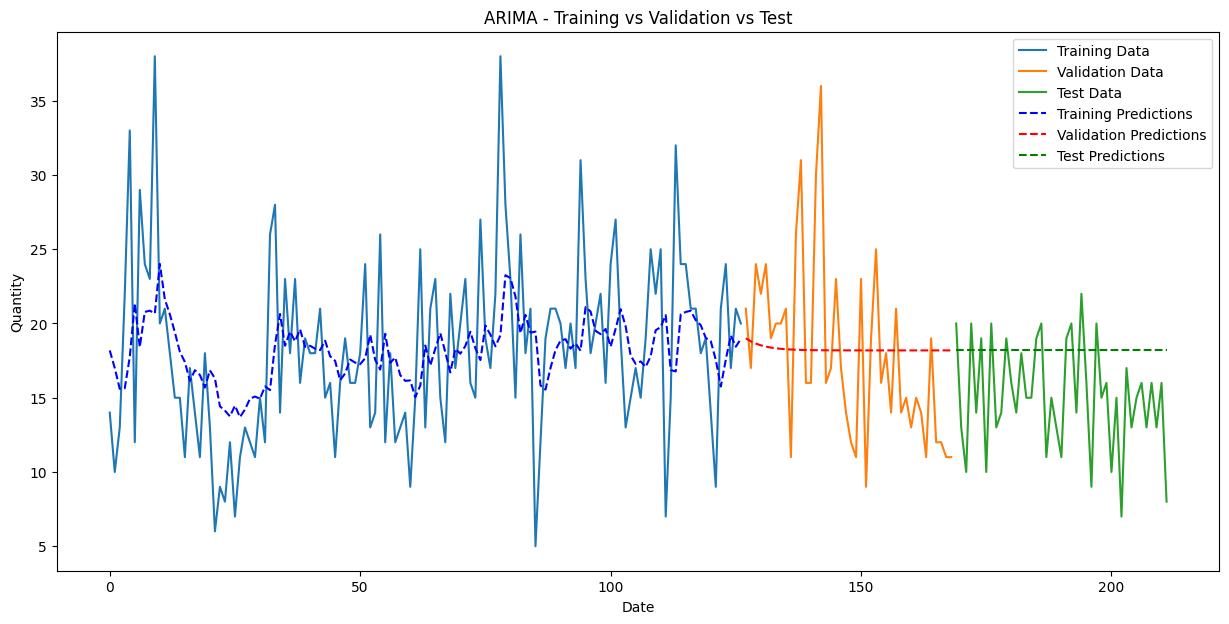

Validation Set Metrics for ARIMA:
MSE: 35.05135718042404, MAE: 4.746750557674151, MAPE: 29.09%

Test Set Metrics for ARIMA:
MSE: 22.73237289436732, MAE: 3.9289722056512426, MAPE: 33.28%


In [601]:
plot_predictions_and_metrics(train_df, val_df, test_df, predictions_train, predictions_val, predictions_test, model_name='ARIMA')

<table>
  <tr>
    <th>Metrics</th>
    <th>Validation set</th>
    <th>Test set</th>
  </tr>
  <tr>
    <th>Mean Squared Error</th>
    <td>35.05135718042404</td>
    <td>22.73237289436732</td>
  </tr>
  <tr>
    <th>Mean Absolute Error</th>
    <td>4.746750557674151</td>
    <td>3.9289722056512426</td>
  </tr>
</table>

***
# nxt
***